<a href="https://colab.research.google.com/github/yanna-torres/CKP9011-ciencia-de-dados/blob/lista-03/lista03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Lista 03 - Análise de Dados
        
> Yanna Torres Gonçalves
>
> Mestrado em Ciências da Computação
>
> Matrícula: 587299

In [ ]:
!pip install plotnine statsmodels wordcloud networkx pyvis

In [ ]:
import pandas as pd
import numpy as np
import re
import duckdb
import math
import matplotlib.pyplot as plt
from plotnine import *
import scipy
import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import seaborn as sns
from wordcloud import WordCloud
import networkx as nx
from pyvis.network import Network
from collections import Counter
from itertools import combinations
from sklearn.preprocessing import StandardScaler
%matplotlib inline

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

## a) Ler o dataset fakeTelegram.BR_2022.csv

Utilizamos o mesmo dataset da lista 01, acessando pelo mesmo link.

[https://github.com/yanna-torres/CKP9011-ciencia-de-dados/blob/lista-01/data/fakeTelegram.BR_2022.csv](https://github.com/yanna-torres/CKP9011-ciencia-de-dados/blob/lista-01/data/fakeTelegram.BR_2022.csv)

In [3]:
data_url = "https://media.githubusercontent.com/media/yanna-torres/CKP9011-ciencia-de-dados/refs/heads/lista-01/data/fakeTelegram.BR_2022.csv"

df = pd.read_csv(data_url)

In [4]:
df.describe()

,dataset_info_id,score_sentiment,score_misinformation,id_message
count,557586.0,444157.000000,167238.000000,5.575860e+05
mean,5.0,0.017330,0.312245,4.450617e+05
std,0.0,0.464165,0.293699,4.860211e+05
min,5.0,-1.000000,0.000003,2.000000e+00
25%,5.0,-0.177900,0.078454,2.127500e+04
50%,5.0,0.000000,0.197577,1.210935e+05
75%,5.0,0.318200,0.490351,9.726045e+05
max,5.0,0.999200,1.000000,1.516436e+06


## b) Remova os trava-zaps

Utilizamos a mesma função da lista 01 criada para validar os dados da coluna `trava_zap`. Após atualizar a coluna, criamos um novo dataframe com os dados sem trava-zaps.

In [5]:
def has_trava_zap(message):
  if not isinstance(message, str):
    return False  # Garante que só analisa strings

  # Regra 1: muito longo
  if len(message) > 10000:
    return True

  # Regra 2: caracteres invisíveis
  invisible = ''.join(chr(c) for c in range(0x200B, 0x200F + 1)) + '\uFEFF'
  if sum(message.count(c) for c in invisible) > 100:
    return True

  # Regra 3: emojis repetidos
  emoji_pattern = re.compile("[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF"
                              "\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+", flags=re.UNICODE)
  emojis = emoji_pattern.findall(message)
  if any(len(e) > 20 for e in emojis):
    return True

  # Regra 4: baixa diversidade
  unique = set(message)
  if len(unique) < 10 and len(message) > 500:
    return True

  return False

In [6]:
df['trava_zap'] = df['text_content_anonymous'].apply(has_trava_zap)

In [7]:
df_clean = df[df['trava_zap'] == False]

In [8]:
df_clean.drop(columns=['trava_zap'], inplace=True)

<ipython-input-8-d18d2c2b7bb2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
df_clean.describe()

,dataset_info_id,score_sentiment,score_misinformation,id_message
count,556305.0,442876.000000,166416.000000,5.563050e+05
mean,5.0,0.017676,0.311496,4.448514e+05
std,0.0,0.463547,0.293146,4.859544e+05
min,5.0,-1.000000,0.000003,2.000000e+00
25%,5.0,-0.177900,0.078334,2.125100e+04
50%,5.0,0.000000,0.196892,1.208690e+05
75%,5.0,0.318200,0.488192,9.724220e+05
max,5.0,0.999200,1.000000,1.516436e+06


## c) Remover as linhas repetidas

In [10]:
df_clean = df_clean.drop_duplicates()

In [11]:
df_clean.describe()

,dataset_info_id,score_sentiment,score_misinformation,id_message
count,556305.0,442876.000000,166416.000000,5.563050e+05
mean,5.0,0.017676,0.311496,4.448514e+05
std,0.0,0.463547,0.293146,4.859544e+05
min,5.0,-1.000000,0.000003,2.000000e+00
25%,5.0,-0.177900,0.078334,2.125100e+04
50%,5.0,0.000000,0.196892,1.208690e+05
75%,5.0,0.318200,0.488192,9.724220e+05
max,5.0,0.999200,1.000000,1.516436e+06


## d) Remover textos com menos de 5 palavras

In [12]:
df_clean = df_clean[df_clean['text_content_anonymous'].str.split().str.len() >= 5]

In [13]:
df.describe()

,dataset_info_id,score_sentiment,score_misinformation,id_message
count,557586.0,444157.000000,167238.000000,5.575860e+05
mean,5.0,0.017330,0.312245,4.450617e+05
std,0.0,0.464165,0.293699,4.860211e+05
min,5.0,-1.000000,0.000003,2.000000e+00
25%,5.0,-0.177900,0.078454,2.127500e+04
50%,5.0,0.000000,0.197577,1.210935e+05
75%,5.0,0.318200,0.490351,9.726045e+05
max,5.0,0.999200,1.000000,1.516436e+06


---

## Pré-processamento com Colunas Auxiliares e DuckDB

Para facilitar a recuperação de dados em alguns casos, vamos criar colunas auxiliares e também vamos utilizar o duckdb.

In [14]:
stop_words = set(stopwords.words('portuguese', 'english'))

def clean_text(text):
  if not isinstance(text, str):
    return ''
  text_no_punct = text.translate(str.maketrans('', '', string.punctuation))
  tokens = word_tokenize(text_no_punct)
  filtered = [word for word in tokens if word.lower() not in stop_words]
  return ' '.join(filtered)

df_clean['text_no_stopwords'] = df_clean['text_content_anonymous'].apply(clean_text)

In [15]:
df_clean['word_count'] = df_clean['text_content_anonymous'].apply(lambda x: len(x.split()) if pd.notnull(x) else 0)

In [88]:
text_counts = df_clean['text_content_anonymous'].value_counts()
df_clean['viral'] = df_clean['text_content_anonymous'].apply(lambda x: True if pd.notnull(x) and text_counts[x] > 1 else False)

In [ ]:
conn = duckdb.connect()

conn.execute("CREATE TABLE messages AS SELECT * FROM df_clean")

In [18]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338045 entries, 0 to 557585
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   date_message            338045 non-null  object 
 1   id_member_anonymous     142383 non-null  object 
 2   id_group_anonymous      338045 non-null  object 
 3   media                   126125 non-null  object 
 4   media_type              126125 non-null  object 
 5   media_url               82697 non-null   object 
 6   has_media               338045 non-null  bool   
 7   has_media_url           338045 non-null  bool   
 8   text_content_anonymous  338045 non-null  object 
 9   dataset_info_id         338045 non-null  int64  
 10  date_system             338045 non-null  object 
 11  score_sentiment         337998 non-null  float64
 12  score_misinformation    166402 non-null  float64
 13  id_message              338045 non-null  int64  
 14  message_type            3

In [22]:
numeric_columns = [
    "score_sentiment",
    "score_misinformation"
    "word_count"
]

In [83]:
category_columns = [
    "media_type",
    "has_media",
    "message_type",
    "messenger",
    "viral"
]

## e) Para cada atributo numérico apresente

### 1. Medidas de Tendência Central

*   Média Aritmética
*   Mediana
*   Valor máximo e mínimo

In [24]:
numeric_stats_params = {
    'score_sentiment': {
        'mean': df_clean['score_sentiment'].mean(),
        'median': df_clean['score_sentiment'].median(),
        'max': df_clean['score_sentiment'].max(),
        'min': df_clean['score_sentiment'].min()
    },
    'score_misinformation': {
        'mean': df_clean['score_misinformation'].mean(),
        'median': df_clean['score_misinformation'].median(),
        'max': df_clean['score_misinformation'].max(),
        'min': df_clean['score_misinformation'].min()
    },
    'word_count': {
        'mean': df_clean['word_count'].mean(),
        'median': df_clean['word_count'].median(),
        'max': df_clean['word_count'].max(),
        'min': df_clean['word_count'].min()
    }
}

numeric_stats_params_df = pd.DataFrame(numeric_stats_params)
numeric_stats_params_df

,score_sentiment,score_misinformation,word_count
mean,0.022497,0.311514,41.811809
median,0.000000,0.196925,20.000000
max,0.999200,1.000000,994.000000
min,-1.000000,0.000003,5.000000


### 2. Medidas de Variabilidade

*   Desvio em relação à média
*   Variância
*   Desvio Padrão

In [26]:
score_sentiment_mean_deviation = (df_clean['score_sentiment'] - df_clean['score_sentiment'].mean()).abs().mean()
score_sentiment_variance = df_clean['score_sentiment'].var()
score_sentiment_std = df_clean['score_sentiment'].std()

score_misinformation_mean_deviation = (df_clean['score_misinformation'] - df_clean['score_misinformation'].mean()).abs().mean()
score_misinformation_variance = df_clean['score_misinformation'].var()
score_misinformation_std = df_clean['score_misinformation'].std()

word_count_mean_deviation = (df_clean['word_count'] - df_clean['word_count'].mean()).abs().mean()
word_count_variance = df_clean['word_count'].var()
word_count_std = df_clean['word_count'].std()

In [27]:
numeric_stats_variablity_params = {
    'score_sentiment': {
        'mean_deviation': score_sentiment_mean_deviation,
        'variance': score_sentiment_variance,
        'std': score_sentiment_std
    },
    'score_misinformation': {
        'mean_deviation': score_misinformation_mean_deviation,
        'variance': score_misinformation_variance,
        'std': score_misinformation_std
    },
    'word_count': {
        'mean_deviation': word_count_mean_deviation,
        'variance': word_count_variance,
        'std': word_count_std
    }
}

numeric_stats_variablity_params_df = pd.DataFrame(numeric_stats_variablity_params)
numeric_stats_variablity_params_df

,score_sentiment,score_misinformation,word_count
mean_deviation,0.425371,0.243704,35.530442
variance,0.280067,0.085937,5412.600883
std,0.529214,0.293150,73.570380


### 3. Tabela de Frequência e Histograma

#### Score Sentiment

In [28]:
# 1. Número de classes (k) - Regra de Sturges
n_ss = len(df_clean)
k_ss = math.ceil(1 + 3.3 * math.log10(n_ss))

# 2. Intervalo da variável
min_val_ss = df_clean['score_sentiment'].min()
max_val_ss = df_clean['score_sentiment'].max()

# 3. Amplitude dos intervalos
amplitude_ss = (max_val_ss - min_val_ss) / k_ss

# 4. Criar os intervalos de classe
bins_ss = [min_val_ss + i * amplitude_ss for i in range(k_ss+1)]
labels_ss = [f"[{round(bins_ss[i], 2)}, {round(bins_ss[i+1], 2)})" for i in range(k_ss)]

# 5. Classificar os dados
df_clean['classe_ss'] = pd.cut(df_clean['score_sentiment'], bins=bins_ss, labels=labels_ss, include_lowest=True, right=False)

# 6. Frequências
frequencia_abs_ss = df_clean['classe_ss'].value_counts().reindex(labels_ss, fill_value=0)
frequencia_rel_ss = (frequencia_abs_ss / n_ss).round(4)
frequencia_per_ss = (frequencia_rel_ss * 100).round(2)
frequencia_acum_per_ss = frequencia_per_ss.cumsum()
densidade_ss = (frequencia_rel_ss / amplitude_ss).round(4)
# Calcular pontos médios de cada classe
pontos_medios_ss = [round((bins_ss[i] + bins_ss[i+1]) / 2, 4) for i in range(k_ss)]


# 7. Tabela final
tabela_frequencia_ss = pd.DataFrame({
    'Classe': labels_ss,
    'Frequência Absoluta': frequencia_abs_ss.values,
    'Frequência Relativa': frequencia_rel_ss.values,
    'Frequência Percentual': frequencia_per_ss.values,
    'Frequência Acumulada (%)': frequencia_acum_per_ss.values,
    'Densidade': densidade_ss.values,
    'Ponto Médio': pontos_medios_ss,
})


# 8. Exibir
print("Tabela de Frequência: Score Sentiment")
tabela_frequencia_ss

Tabela de Frequência: Score Sentiment


,Classe,Frequência Absoluta,Frequência Relativa,Frequência Percentual,Frequência Acumulada (%),Densidade,Ponto Médio
0,"[-1.0, -0.9)",12751,0.0377,3.77,3.77,0.3772,-0.9500
1,"[-0.9, -0.8)",12620,0.0373,3.73,7.50,0.3731,-0.8501
2,"[-0.8, -0.7)",13896,0.0411,4.11,11.61,0.4112,-0.7501
3,"[-0.7, -0.6)",14008,0.0414,4.14,15.75,0.4142,-0.6501
4,"[-0.6, -0.5)",14658,0.0434,4.34,20.09,0.4342,-0.5502
5,"[-0.5, -0.4)",15661,0.0463,4.63,24.72,0.4632,-0.4502
6,"[-0.4, -0.3)",10108,0.0299,2.99,27.71,0.2991,-0.3503
7,"[-0.3, -0.2)",14998,0.0444,4.44,32.15,0.4442,-0.2503
8,"[-0.2, -0.1)",14222,0.0421,4.21,36.36,0.4212,-0.1503
9,"[-0.1, -0.0)",4209,0.0125,1.25,37.61,0.1251,-0.0504


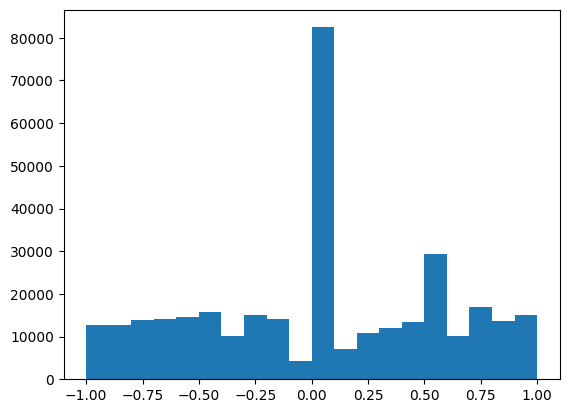

In [29]:
plt.hist(df_clean['score_sentiment'], bins=k_ss)
plt.show()

#### Score Misinformation

In [30]:
# 1. Número de classes (k) - Regra de Sturges
n_sm = len(df_clean)
k_sm = math.ceil(1 + 3.3 * math.log10(n_sm))

# 2. Intervalo da variável
min_val_sm = df_clean['score_misinformation'].min()
max_val_sm = df_clean['score_misinformation'].max()

# 3. Amplitude dos intervalos
amplitude_sm = (max_val_sm - min_val_sm) / k_sm

# 4. Criar os intervalos de classe
bins_sm = [min_val_sm + i * amplitude_sm for i in range(k_sm+1)]
labels_sm = [f"[{round(bins_sm[i], 2)}, {round(bins_sm[i+1], 2)})" for i in range(k_sm)]

# 5. Classificar os dados
df_clean['classe_sm'] = pd.cut(df_clean['score_misinformation'], bins=bins_sm, labels=labels_sm, include_lowest=True, right=False)

# 6. Frequências
frequencia_abs_sm = df_clean['classe_sm'].value_counts().reindex(labels_sm, fill_value=0)
frequencia_rel_sm = (frequencia_abs_sm / n_sm).round(4)
frequencia_per_sm = (frequencia_rel_sm * 100).round(2)
frequencia_acum_per_sm = frequencia_per_sm.cumsum()
densidade_sm = (frequencia_rel_sm / amplitude_sm).round(4)
# Calcular pontos médios de cada classe
pontos_medios_sm = [round((bins_sm[i] + bins_sm[i+1]) / 2, 4) for i in range(k_sm)]


# 7. Tabela final
tabela_frequencia_sm = pd.DataFrame({
    'Classe': labels_sm,
    'Frequência Absoluta': frequencia_abs_sm.values,
    'Frequência Relativa': frequencia_rel_sm.values,
    'Frequência Percentual': frequencia_per_sm.values,
    'Frequência Acumulada (%)': frequencia_acum_per_sm.values,
    'Densidade': densidade_sm.values,
    'Ponto Médio': pontos_medios_sm,
})


# 8. Exibir
print("Tabela de Frequência: Score Misinformation")
tabela_frequencia_sm


Tabela de Frequência: Score Misinformation


,Classe,Frequência Absoluta,Frequência Relativa,Frequência Percentual,Frequência Acumulada (%),Densidade,Ponto Médio
0,"[0.0, 0.05)",27892,0.0825,8.25,8.25,1.650,0.025
1,"[0.05, 0.1)",23074,0.0683,6.83,15.08,1.366,0.075
2,"[0.1, 0.15)",18951,0.0561,5.61,20.69,1.122,0.125
3,"[0.15, 0.2)",14012,0.0415,4.15,24.84,0.830,0.175
4,"[0.2, 0.25)",11003,0.0325,3.25,28.09,0.650,0.225
5,"[0.25, 0.3)",8088,0.0239,2.39,30.48,0.478,0.275
6,"[0.3, 0.35)",6850,0.0203,2.03,32.51,0.406,0.325
7,"[0.35, 0.4)",5942,0.0176,1.76,34.27,0.352,0.375
8,"[0.4, 0.45)",5376,0.0159,1.59,35.86,0.318,0.425
9,"[0.45, 0.5)",4663,0.0138,1.38,37.24,0.276,0.475


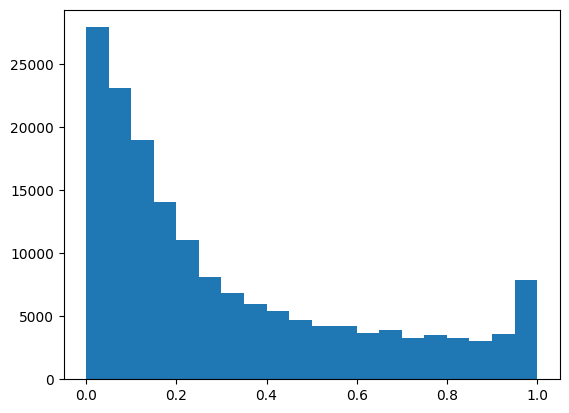

In [31]:
plt.hist(df_clean['score_misinformation'], bins=k_sm)
plt.show()

#### Word Count

In [35]:
# 1. Número de classes (k) - Regra de Sturges
n_wc = len(df_clean)
k_wc = math.ceil(1 + 3.3 * math.log10(n_wc))

# 2. Intervalo da variável
min_val_wc = df_clean['word_count'].min()
max_val_wc = df_clean['word_count'].max()

# 3. Amplitude dos intervalos
amplitude_wc = (max_val_wc - min_val_wc) / k_wc

# 4. Criar os intervalos de classe
bins_wc = [min_val_wc + i * amplitude_wc for i in range(k_wc+1)]
labels_wc = [f"[{round(bins_wc[i], 2)}, {round(bins_wc[i+1], 2)})" for i in range(k_wc)]

# 5. Classificar os dados
df_clean['classe_wc'] = pd.cut(df_clean['word_count'], bins=bins_wc, labels=labels_wc, include_lowest=True, right=False)

# 6. Frequências
frequencia_abs_wc = df_clean['classe_wc'].value_counts().reindex(labels_wc, fill_value=0)
frequencia_rel_wc = (frequencia_abs_wc / n_wc).round(4)
frequencia_per_wc = (frequencia_rel_wc * 100).round(2)
frequencia_acum_per_wc = frequencia_per_wc.cumsum()
densidade_wc = (frequencia_rel_wc / amplitude_wc).round(4)
# Calcular pontos médios de cada classe
pontos_medios_wc = [round((bins_wc[i] + bins_wc[i+1]) / 2, 4) for i in range(k_wc)]


# 7. Tabela final
tabela_frequencia_wc = pd.DataFrame({
    'Classe': labels_wc,
    'Frequência Absoluta': frequencia_abs_wc.values,
    'Frequência Relativa': frequencia_rel_wc.values,
    'Frequência Percentual': frequencia_per_wc.values,
    'Frequência Acumulada (%)': frequencia_acum_per_wc.values,
    'Densidade': densidade_wc.values,
    'Ponto Médio': pontos_medios_wc,
})


# 8. Exibir
print("Tabela de Frequência: Word Count")
tabela_frequencia_wc


Tabela de Frequência: Word Count


,Classe,Frequência Absoluta,Frequência Relativa,Frequência Percentual,Frequência Acumulada (%),Densidade,Ponto Médio
0,"[5.0, 54.45)",280703,0.8304,83.04,83.04,0.0168,29.725
1,"[54.45, 103.9)",33177,0.0981,9.81,92.85,0.0020,79.175
2,"[103.9, 153.35)",9834,0.0291,2.91,95.76,0.0006,128.625
3,"[153.35, 202.8)",4296,0.0127,1.27,97.03,0.0003,178.075
4,"[202.8, 252.25)",2435,0.0072,0.72,97.75,0.0001,227.525
5,"[252.25, 301.7)",1375,0.0041,0.41,98.16,0.0001,276.975
6,"[301.7, 351.15)",1372,0.0041,0.41,98.57,0.0001,326.425
7,"[351.15, 400.6)",1131,0.0033,0.33,98.90,0.0001,375.875
8,"[400.6, 450.05)",709,0.0021,0.21,99.11,0.0000,425.325
9,"[450.05, 499.5)",508,0.0015,0.15,99.26,0.0000,474.775


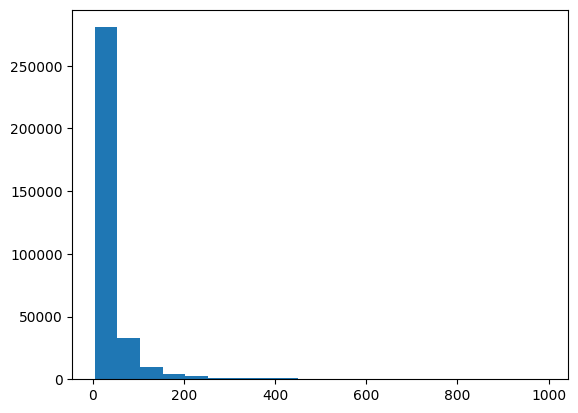

In [36]:
plt.hist(df_clean['word_count'], bins=k_sm)
plt.show()

### 4. Boxplot

<Axes: >

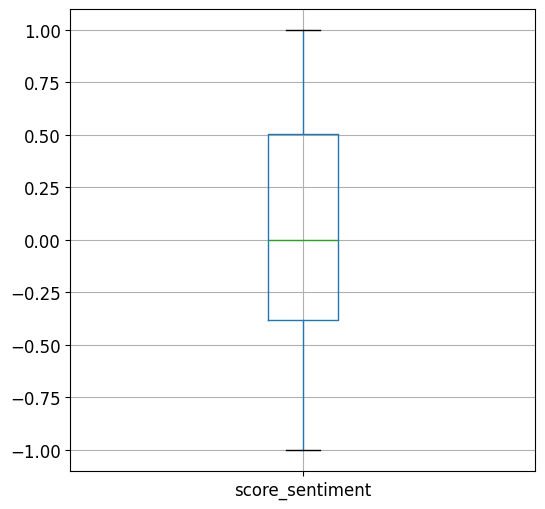

In [34]:
df_clean.boxplot(column=['score_sentiment'], fontsize='large', figsize=(6,6))

<Axes: >

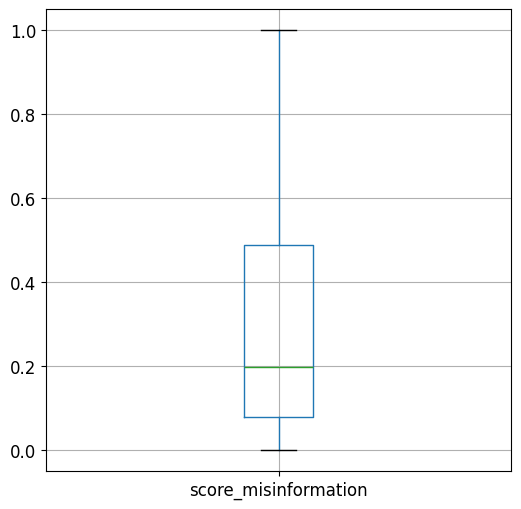

In [28]:
df_clean.boxplot(column=['score_misinformation'], fontsize='large', figsize=(6,6))

<Axes: >

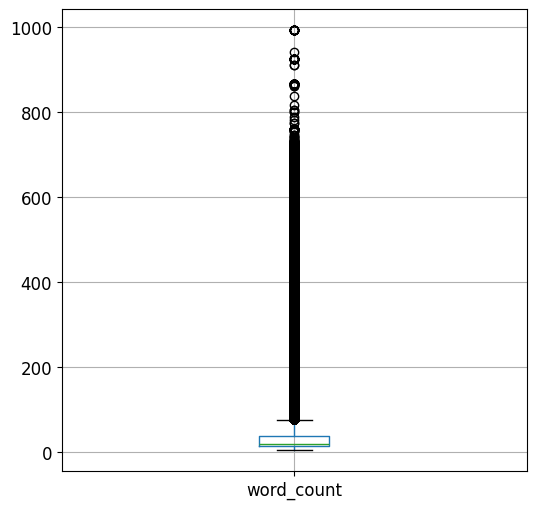

In [37]:
df_clean.boxplot(column=['word_count'], fontsize='large', figsize=(6,6))

### 5. QQ-Plot

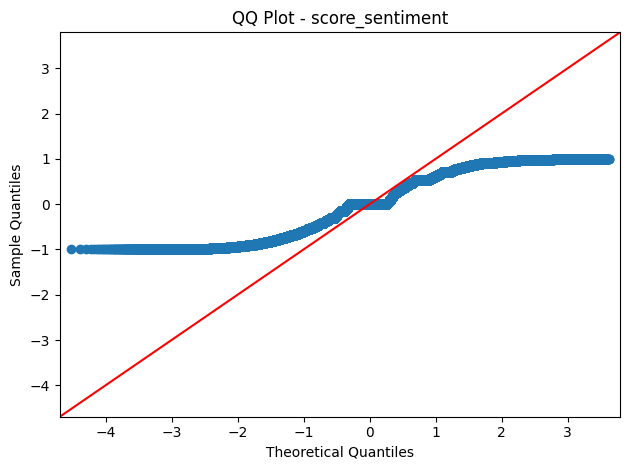

In [38]:
sm.qqplot(df_clean['score_sentiment'], line='45')
plt.title('QQ Plot - score_sentiment')
plt.tight_layout()
plt.show()

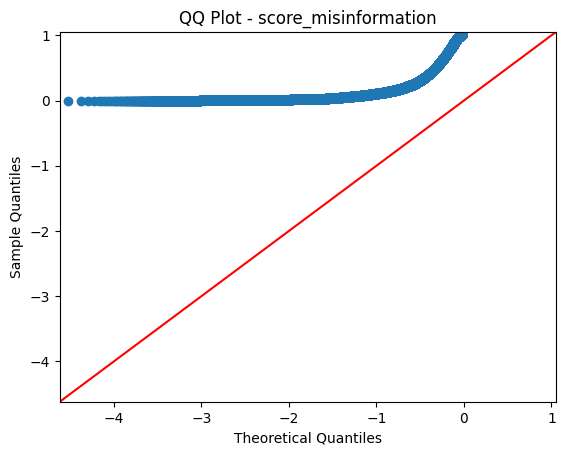

In [39]:
sm.qqplot(df_clean['score_misinformation'], line='45')
plt.title('QQ Plot - score_misinformation')
plt.show()

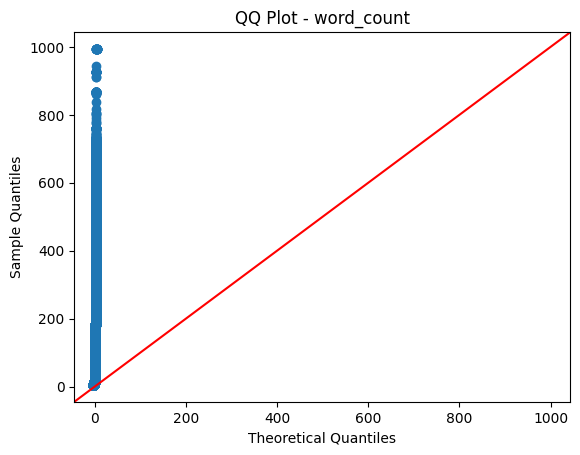

In [40]:
sm.qqplot(df_clean['word_count'], line='45')
plt.title('QQ Plot - word_count')
plt.show()

### 6. Teste de Normalidade

#### Score Sentiment

In [41]:
shapiro_ss = stats.shapiro(df_clean['score_sentiment'].dropna())

print(f"Shapiro-Wilk Statistic: {shapiro_ss.statistic}")
print(f"p-value: {shapiro_ss.pvalue}")

print(f'Is Normal: {shapiro_ss.pvalue >= 0.05}')

Shapiro-Wilk Statistic: 0.9623856812853971
p-value: 8.897899686071102e-109
Is Normal: False


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 337998.


In [42]:
lilliefors_ss = statsmodels.stats.diagnostic.lilliefors(df_clean['score_sentiment'].dropna(), dist='norm', pvalmethod='table')

print(f"Statistic: {lilliefors_ss[0]}")
print(f"p-value: {lilliefors_ss[1]}")

print(f'Is Normal: {lilliefors_ss[1] >= 0.05}')

Statistic: 0.12152561509216186
p-value: 0.0009999999999998899
Is Normal: False


In [43]:
jarque_bera_ss = stats.jarque_bera(df_clean['score_sentiment'].dropna())

print(f"Statistic: {jarque_bera_ss.statistic}")
print(f"p-value: {jarque_bera_ss.pvalue}")

print(f'Is Normal: {jarque_bera_ss.pvalue >= 0.05}')

Statistic: 12054.398174723185
p-value: 0.0
Is Normal: False


In [44]:
normaltest_ss = stats.normaltest(df_clean['score_sentiment'].dropna())

print(f"Statistic: {normaltest_ss.statistic}")
print(f"p-value: {normaltest_ss.pvalue}")

print(f'Is Normal: {normaltest_ss.pvalue >= 0.05}')

Statistic: 51573.95893688736
p-value: 0.0
Is Normal: False


#### Score Misinformation

In [45]:
shapiro_sm = stats.shapiro(df_clean['score_misinformation'].dropna())

print(f"Shapiro-Wilk Statistic: {shapiro_ss.statistic}")
print(f"p-value: {shapiro_ss.pvalue}")

print(f'Is Normal: {shapiro_ss.pvalue >= 0.05}')

Shapiro-Wilk Statistic: 0.9623856812853971
p-value: 8.897899686071102e-109
Is Normal: False


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 166402.


In [46]:
lilliefors_sm = statsmodels.stats.diagnostic.lilliefors(df_clean['score_misinformation'].dropna(), dist='norm', pvalmethod='table')

print(f"Statistic: {lilliefors_ss[0]}")
print(f"p-value: {lilliefors_ss[1]}")

print(f'Is Normal: {lilliefors_ss[1] >= 0.05}')

Statistic: 0.12152561509216186
p-value: 0.0009999999999998899
Is Normal: False


In [47]:
jarque_bera_sm = stats.jarque_bera(df_clean['score_misinformation'].dropna())

print(f"Statistic: {jarque_bera_ss.statistic}")
print(f"p-value: {jarque_bera_ss.pvalue}")

print(f'Is Normal: {jarque_bera_ss.pvalue >= 0.05}')

Statistic: 12054.398174723185
p-value: 0.0
Is Normal: False


In [48]:
normaltest_sm = stats.normaltest(df_clean['score_misinformation'].dropna())

print(f"Statistic: {normaltest_ss.statistic}")
print(f"p-value: {normaltest_ss.pvalue}")

print(f'Is Normal: {normaltest_ss.pvalue >= 0.05}')

Statistic: 51573.95893688736
p-value: 0.0
Is Normal: False


#### Word Count

In [49]:
shapiro_wc = stats.shapiro(df_clean['word_count'].dropna())

print(f"Shapiro-Wilk Statistic: {shapiro_wc.statistic}")
print(f"p-value: {shapiro_wc.pvalue}")

print(f'Is Normal: {shapiro_wc.pvalue >= 0.05}')

Shapiro-Wilk Statistic: 0.41819183875187793
p-value: 1.408371431708459e-196
Is Normal: False


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 338045.


In [50]:
lilliefors_wc = statsmodels.stats.diagnostic.lilliefors(df_clean['word_count'].dropna(), dist='norm', pvalmethod='table')

print(f"Statistic: {lilliefors_wc[0]}")
print(f"p-value: {lilliefors_wc[1]}")

print(f'Is Normal: {lilliefors_wc[1] >= 0.05}')

Statistic: 0.30841016785316333
p-value: 0.0009999999999998899
Is Normal: False


In [51]:
jarque_bera_wc = stats.jarque_bera(df_clean['word_count'].dropna())

print(f"Statistic: {jarque_bera_wc.statistic}")
print(f"p-value: {jarque_bera_wc.pvalue}")

print(f'Is Normal: {jarque_bera_wc.pvalue >= 0.05}')

Statistic: 22793597.909993492
p-value: 0.0
Is Normal: False


In [52]:
normaltest_wc = stats.normaltest(df_clean['word_count'].dropna())

print(f"Statistic: {normaltest_wc.statistic}")
print(f"p-value: {normaltest_wc.pvalue}")

print(f'Is Normal: {normaltest_wc.pvalue >= 0.05}')

Statistic: 361667.6018329772
p-value: 0.0
Is Normal: False


### 7. Best Fit Distribution (usando diferentes métodos)

In [53]:
dist_names = [
    'beta',
    'expon',
    'gamma',
    'lognorm',
    'norm',
    'pearson3',
    't',
    'triang',
    'uniform',
    'weibull_min',
    'weibull_max'
]

In [54]:
def check_distribution(dist_names, y_std, column_name):

    p_values = []
    distance = []
    D_less_p = []

    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(y_std)

        if distribution != "norm":
            D, p = scipy.stats.kstest(y_std, distribution, args=param)
        else:
            D, p = scipy.stats.kstest(y_std, distribution,  alternative='greater')

        #p = np.around(p, 5)
        p_values.append(p)

        #D = np.around(D, 5)
        distance.append(D)

        if D<p:
            D_less_p.append("yes")
        else:
            D_less_p.append("no")

    results = pd.DataFrame()
    results['Distribution'] = dist_names
    results['Distance'] = distance
    results['p_value'] = p_values
    results['D<p'] = D_less_p

    results.sort_values(['p_value'], ascending=False, inplace=True)


    print (f'\n${column_name} - Distributions sorted by goodness of fit:')
    print ('----------------------------------------')
    print (results)

#### Score Sentiment

In [55]:
scores_ss = df_clean['score_sentiment']
scores_clean_ss = scores_ss.dropna()
z_scores_ss = stats.zscore(scores_clean_ss)

In [56]:
check_distribution(dist_names, z_scores_ss, 'score_sentiment')

/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:6912: RuntimeWarning: invalid value encountered in log



$score_sentiment - Distributions sorted by goodness of fit:
----------------------------------------
   Distribution  Distance  p_value D<p
0          beta  0.118371      0.0  no
1         expon  0.247807      0.0  no
2         gamma  0.118801      0.0  no
3       lognorm  0.119172      0.0  no
4          norm  0.121526      0.0  no
5      pearson3  0.131865      0.0  no
6             t  0.121526      0.0  no
7        triang  0.118145      0.0  no
8       uniform  0.124071      0.0  no
9   weibull_min  0.114634      0.0  no
10  weibull_max  0.143595      0.0  no


<ipython-input-57-d565f9e86bab>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



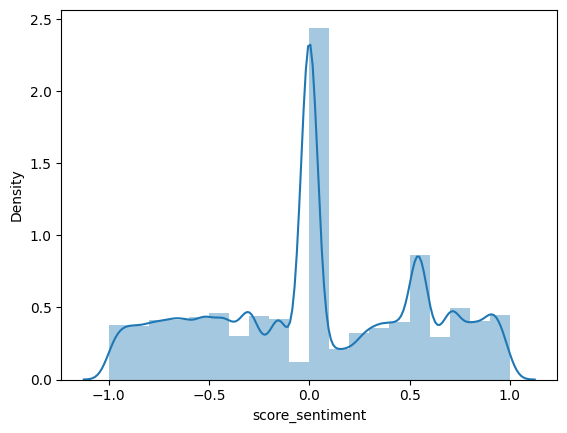

In [57]:
sns.distplot(scores_clean_ss, bins=k_ss)
plt.show()

#### Score Misinformation

In [58]:
scores_sm = df_clean['score_misinformation']
scores_clean_sm = scores_sm.dropna()
z_scores_sm = stats.zscore(scores_clean_sm)

In [59]:
check_distribution(dist_names, z_scores_sm, 'score_misinformation')

/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:6912: RuntimeWarning: invalid value encountered in log



$score_misinformation - Distributions sorted by goodness of fit:
----------------------------------------
   Distribution  Distance        p_value D<p
5      pearson3  0.046544  1.043994e-313  no
2         gamma  0.046708  6.456362e-316  no
0          beta  0.107844   0.000000e+00  no
1         expon  0.048517   0.000000e+00  no
3       lognorm  0.068144   0.000000e+00  no
4          norm  0.155665   0.000000e+00  no
6             t  0.155665   0.000000e+00  no
7        triang  0.176090   0.000000e+00  no
8       uniform  0.322736   0.000000e+00  no
9   weibull_min  0.047291   0.000000e+00  no
10  weibull_max  0.114616   0.000000e+00  no


<ipython-input-60-172a8ffaefcb>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



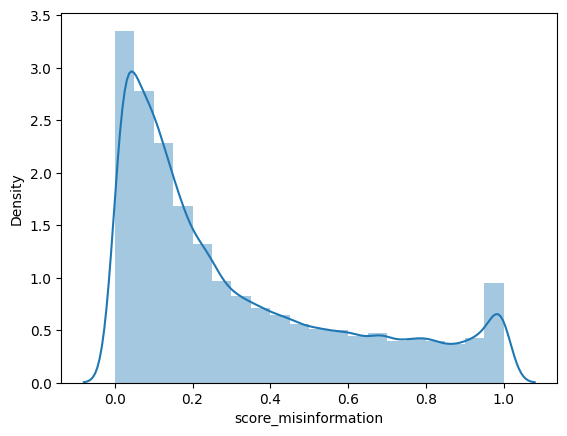

In [60]:
sns.distplot(scores_clean_sm, bins=k_sm)
plt.show()

#### Word Count

In [61]:
scores_wc = df_clean['word_count']
scores_clean_wc = scores_wc.dropna()
z_scores_wc = stats.zscore(scores_clean_wc)

In [62]:
check_distribution(dist_names, z_scores_wc, 'word_count')

/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:6912: RuntimeWarning: invalid value encountered in log



$word_count - Distributions sorted by goodness of fit:
----------------------------------------
   Distribution  Distance  p_value D<p
0          beta  0.169994      0.0  no
1         expon  0.193813      0.0  no
2         gamma  0.600445      0.0  no
3       lognorm  0.101223      0.0  no
4          norm  0.272028      0.0  no
5      pearson3  0.146885      0.0  no
6             t  0.204806      0.0  no
7        triang  0.632510      0.0  no
8       uniform  0.831093      0.0  no
9   weibull_min  0.242006      0.0  no
10  weibull_max  0.212255      0.0  no


<ipython-input-63-18ac53cda663>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



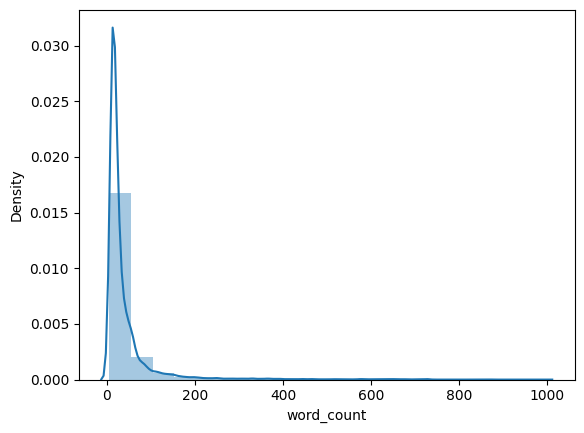

In [63]:
sns.distplot(scores_clean_wc, bins=k_wc)
plt.show()

## f) Para cada par de atributos númericos apresente

### 1. O Coeficiente de Correlação apropriado

Como nenhum dado segue a distribuição normal, utilizaremos a Correlação de Spearman

In [68]:
valid_data = df_clean[['score_sentiment', 'score_misinformation', 'word_count']].dropna()
v_ss = valid_data['score_sentiment']
v_sm = valid_data['score_misinformation']
v_wc = valid_data['word_count']

In [69]:
correlation, p_value = stats.spearmanr(v_ss, v_sm)

print(f"Coeficiente de Spearman: {correlation}")
print(f"Valor-p: {p_value}")

Coeficiente de Spearman: -0.38877844225991115
Valor-p: 0.0


In [70]:
correlation, p_value = stats.spearmanr(v_ss, v_wc)

print(f"Coeficiente de Spearman: {correlation}")
print(f"Valor-p: {p_value}")

Coeficiente de Spearman: -0.0707741625825646
Valor-p: 9.887903771499055e-184


In [73]:
correlation, p_value = stats.spearmanr(v_sm, v_wc)

print(f"Coeficiente de Spearman: {correlation}")
print(f"Valor-p: {p_value}")

Coeficiente de Spearman: 0.17931518952078246
Valor-p: 0.0


### 2. Um Gráfico de Dispersão

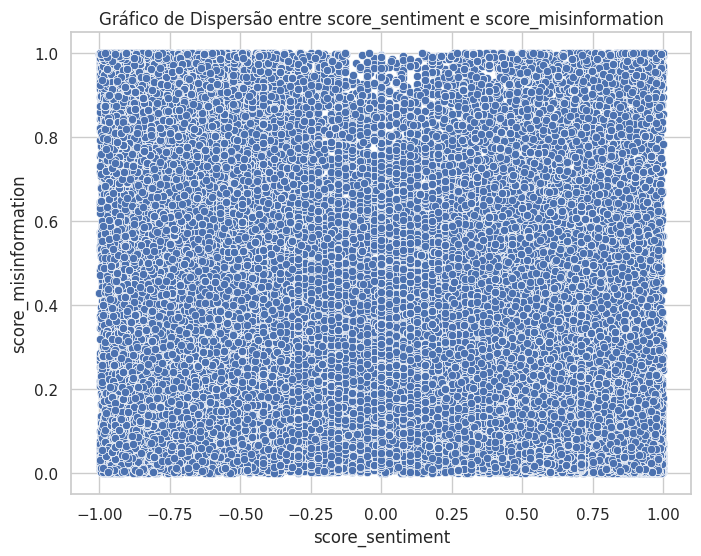

In [74]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.scatterplot(x='score_sentiment', y='score_misinformation', data=valid_data)
plt.title('Gráfico de Dispersão entre score_sentiment e score_misinformation')
plt.show()

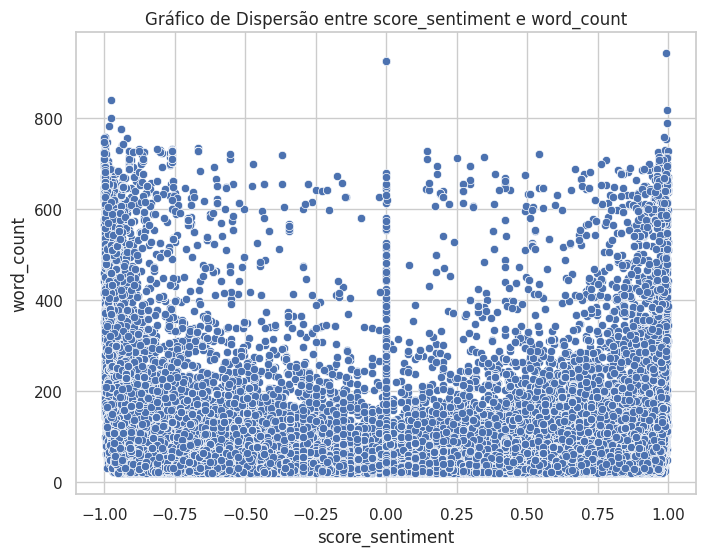

In [76]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.scatterplot(x='score_sentiment', y='word_count', data=valid_data)
plt.title('Gráfico de Dispersão entre score_sentiment e word_count')
plt.show()

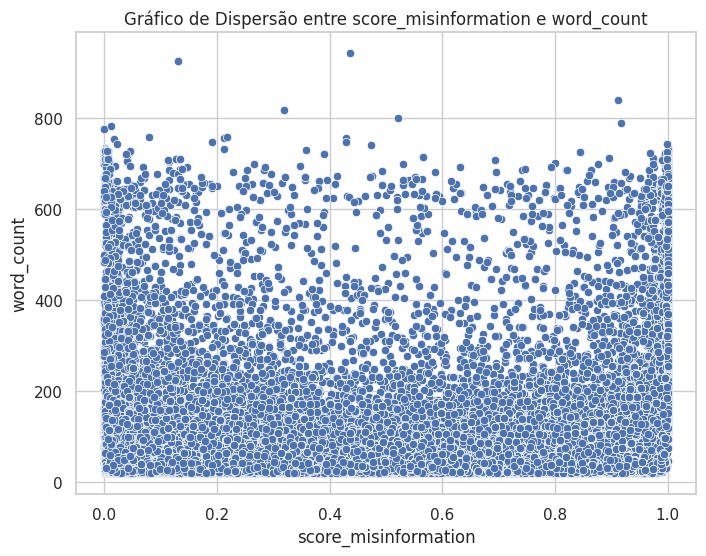

In [82]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.scatterplot(x='score_misinformation', y='word_count', data=valid_data)
plt.title('Gráfico de Dispersão entre score_misinformation e word_count')
plt.show()

## g) Para cada par de atributos categóricos apresente

In [99]:
category_columns

['media_type', 'has_media', 'message_type', 'messenger', 'viral']

In [100]:
categories_valid_data = df_clean[category_columns].dropna()

In [101]:
categories_valid_data.describe()

,media_type,has_media,message_type,messenger,viral
count,126125,126125,126125,126125,126125
unique,41,1,7,1,2
top,image/jpg,True,Imagem,telegram,True
freq,78111,126125,78960,126125,85115


In [108]:
categories_valid_data = categories_valid_data.drop(columns=['has_media', 'messenger'])

### 1. O resultado do método V de Cramer

In [109]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, expected = stats.chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))  # Bias correction
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Create a DataFrame to store the results
columns = categories_valid_data.columns
cramers_v_matrix = pd.DataFrame(index=columns, columns=columns, dtype=float)

# Compute Cramér's V for every pair
for col1 in columns:
    for col2 in columns:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0
        else:
            v = cramers_v(categories_valid_data[col1], categories_valid_data[col2])
            cramers_v_matrix.loc[col1, col2] = v

In [110]:
cramers_v_matrix

,media_type,message_type,viral
media_type,1.000000,0.919455,0.123356
message_type,0.919455,1.000000,0.118222
viral,0.123356,0.118222,1.000000


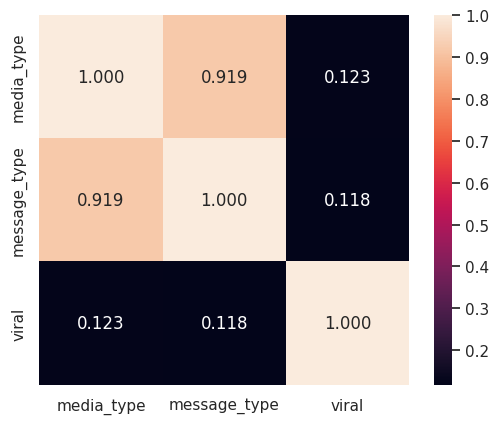

In [116]:
sns.heatmap(cramers_v_matrix, annot=True, fmt=".3f", square=True)
plt.show()

## h) Crie uma visualização (gráfico) para apresentar

### 1. As quantidades de grupos, usuários e mensagens

In [117]:
meta_data_quant = conn.execute("SELECT COUNT(*) AS total_messages, COUNT(DISTINCT id_member_anonymous) AS total_users, COUNT(DISTINCT id_group_anonymous) AS total_groups FROM messages").df()
meta_data_quant

,total_messages,total_users,total_groups
0,338045,11340,177


### 2. A quantidade de mensagens que possuem apenas texto X mídia

In [118]:
quant_messages_by_content = conn.execute("""
SELECT
  COUNT(CASE WHEN text_content_anonymous IS NOT NULL AND has_media = False THEN 1 END) AS only_text,
  COUNT(CASE WHEN has_media = True AND text_content_anonymous IS NOT NULL THEN 1 END) AS with_media
FROM messages
""").df()

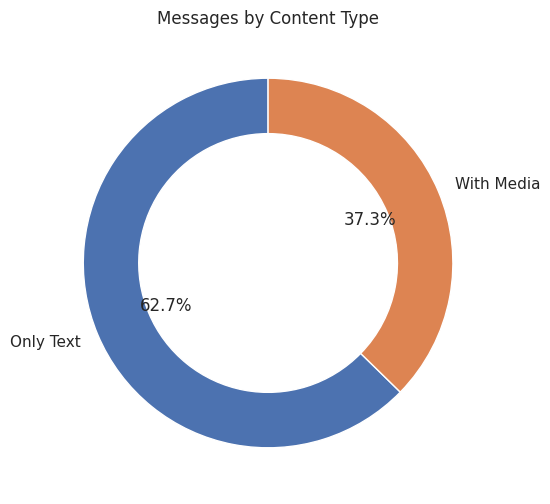

In [161]:
fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts, autotexts = ax.pie(
    quant_messages_by_content.iloc[0].values,
    labels=['Only Text', 'With Media'],
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops=dict(width=0.3)
)

ax.set(aspect="equal", title='Messages by Content Type')

plt.show()

### 3. Quantidade de mensagens por tipo de mídia (jpg, mp4 etc)

In [128]:
quant_messages_per_media_type_df = conn.execute("""
SELECT media_type, COUNT(*) AS total_messages
FROM messages
WHERE has_media = True
GROUP BY media_type
ORDER BY total_messages DESC
LIMIT 10
""").df()

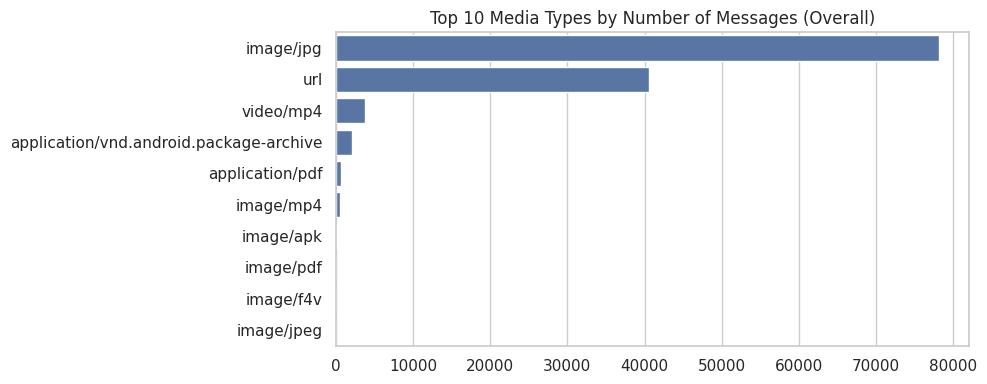

In [135]:
plt.figure(figsize=(10, 4))
sns.barplot(
    data=quant_messages_per_media_type_df,
    x='total_messages',
    y='media_type',
)

plt.title('Top 10 Media Types by Number of Messages (Overall)')
plt.xlabel(None)
plt.ylabel(None)
plt.tight_layout()

plt.show()

In [127]:
media_category_df = conn.execute("""
SELECT
  CASE
    WHEN media_type = 'url' THEN 'url'
    ELSE SPLIT_PART(media_type, '/', 1)
  END AS media_category,
  COUNT(*) AS total_messages
FROM messages
WHERE has_media = TRUE
GROUP BY media_category
ORDER BY total_messages DESC
""").df()
media_category_df

,media_category,total_messages
0,image,78962
1,url,40558
2,video,3780
3,application,2802
4,audio,22
5,text,1


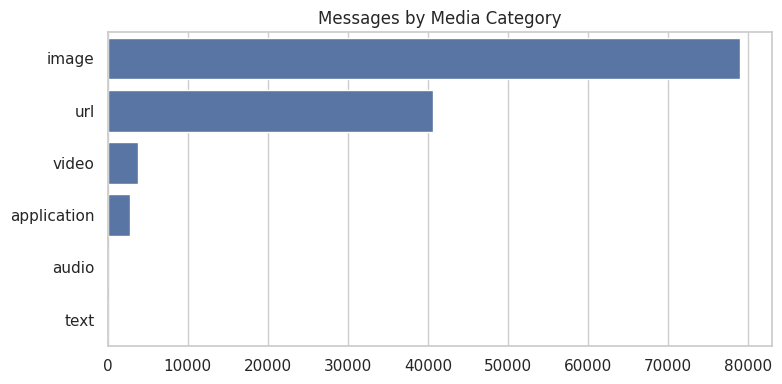

In [136]:
plt.figure(figsize=(8, 4))
sns.barplot(
    data=media_category_df,
    x='total_messages',
    y='media_category',
)

plt.title('Messages by Media Category')
plt.xlabel(None)
plt.ylabel(None)
plt.tight_layout()

plt.show()

### 4. Relação entre a quantidade de mensagens e a quantidade de palavras presente nas mensagens

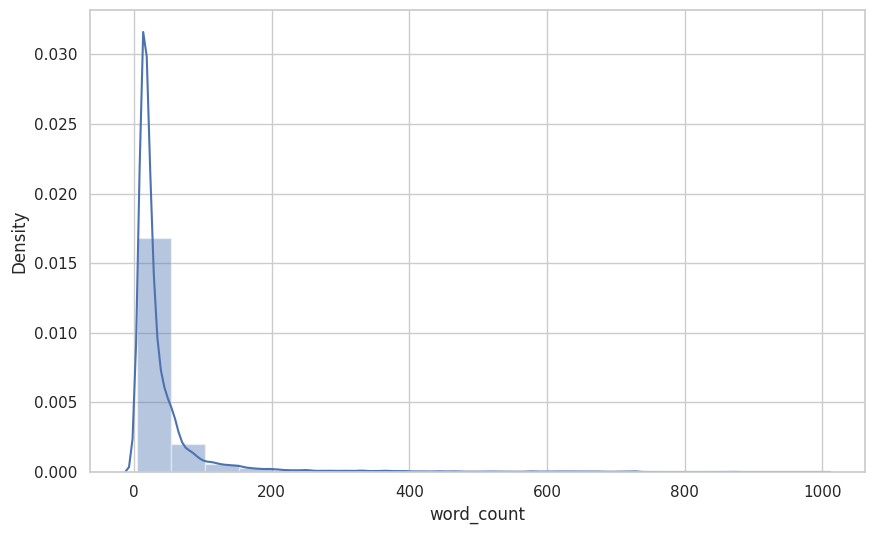

In [151]:
plt.figure(figsize=(10, 6))
sns.distplot(scores_clean_wc, bins=k_wc)
plt.show()

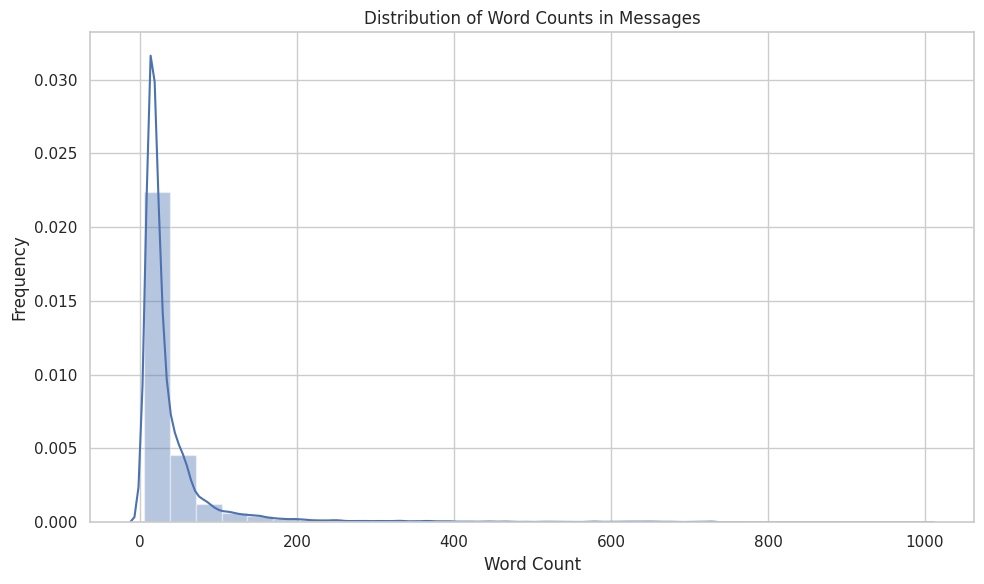

In [156]:
plt.figure(figsize=(10, 6))
sns.distplot(df_clean['word_count'], bins=30)

plt.title('Distribution of Word Counts in Messages')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### 5. Quantidade de mensagens por estado

### 6. Quantidade de usuários por estado

### 7. Relação quantidade de usuários por quantidade de mensagens por estado

### 8. Quantidade de mensagens por país

### 9. Quantidade de mensagens Brasil X Países Estrangeiros

Não há informações sobre estado

### 10. A 30 URLs que mais se repetem

In [166]:
top_urls = conn.execute("""
SELECT media_url as url, COUNT(*) AS total
FROM messages
WHERE url IS NOT NULL
GROUP BY url
ORDER BY total DESC
LIMIT 30
""").df()
top_urls

,url,total
0,t.me/alexeconomia,4046
1,https://youtube.com/c/especulandoosfatosoficial,1607
2,t.me/fimtaproximo,1579
3,t.me/+EWlGMatRZGg3OTlh,1419
4,t.me/+ewZIPdZ42vEyNzJh,772
5,https://t.me/canalselvabrasiloficial,708
6,T.me/Arthur_Senna_Trader2,631
7,t.me/+bseuTTFOO8c5YWFh,515
8,youtube.com/AlexEconomia,445
9,https://t.me/+DnJpx-HxNCFkMmUx,390


### 11. Os 30 domínios que mais se repetem

In [170]:
regex_domains = "LOWER(regexp_extract(regexp_replace(media_url, 'https?://(www\.)?', ''), '^([^/]+)', 1))"
top_domains = conn.execute(f"""
WITH domain_stats AS (
    SELECT
        {regex_domains} AS domain,
        COUNT(*) AS total,
        COUNT(DISTINCT media_url) AS unique_urls,
        COUNT(DISTINCT id_member_anonymous) AS unique_users
    FROM messages
    WHERE media_url IS NOT NULL
    GROUP BY domain
)
SELECT *
FROM domain_stats
ORDER BY total DESC
LIMIT 30

""").df()
top_domains

,domain,total,unique_urls,unique_users
0,t.me,19187,1813,783
1,youtu.be,12936,4439,900
2,youtube.com,7273,1935,456
3,terrabrasilnoticias.com,6460,2297,204
4,jornaldacidadeonline.com.br,4391,798,157
5,instagram.com,1690,797,320
6,pleno.news,1422,690,65
7,twitter.com,1168,579,201
8,aliadosbrasiloficial.com.br,918,353,46
9,verdadecensurada.com.br,792,138,23


### 12. Os 30 usuários mais ativos

In [173]:
top_users = conn.execute("""
SELECT
    id_member_anonymous,
    COUNT(*) AS total,
    COUNT(CASE WHEN has_media THEN 1 ELSE null END) AS media_count
FROM messages
WHERE id_member_anonymous IS NOT NULL
GROUP BY id_member_anonymous
ORDER BY total DESC
LIMIT 30
""").df()
top_users

,id_member_anonymous,total,media_count
0,abe534d581ec6d552243d6955d3c3cd8,12289,0
1,1665e22b0f564cd46d343f7677014821,5452,2972
2,1ac091b8ed5c4e42383f1b4ff4cc9b2d,3235,2820
3,c743967449a387ad2c1c7e03b2c45b36,3017,152
4,d49f81df0c75d1d72bee6c5b2d707da0,1571,0
5,f233cf8b1d4ede06f32199a7e0081bf5,1085,70
6,e8fd8fee8c39342d37993775da7756d5,1027,329
7,e7998863ac2a40086657fab4a6b463c9,921,493
8,c052c859b42c5a1923c22f5a201de746,831,736
9,fa582c9e95da255e44f4c198d0daf3df,816,700


### 13. Relação entre quantidade de mensagens contendo apenas texto e mensagem contendo mídia dos usuários

In [188]:
top_users_breakdown = conn.execute("""
SELECT
    id_member_anonymous,
    COUNT(*) AS total_messages,
    SUM(CASE WHEN has_media THEN 1 ELSE 0 END) AS media_messages,
    SUM(CASE WHEN has_media THEN 0 ELSE 1 END) AS text_only_messages
FROM messages
WHERE id_member_anonymous IS NOT NULL
GROUP BY id_member_anonymous
ORDER BY total_messages DESC
LIMIT 30
""").df()

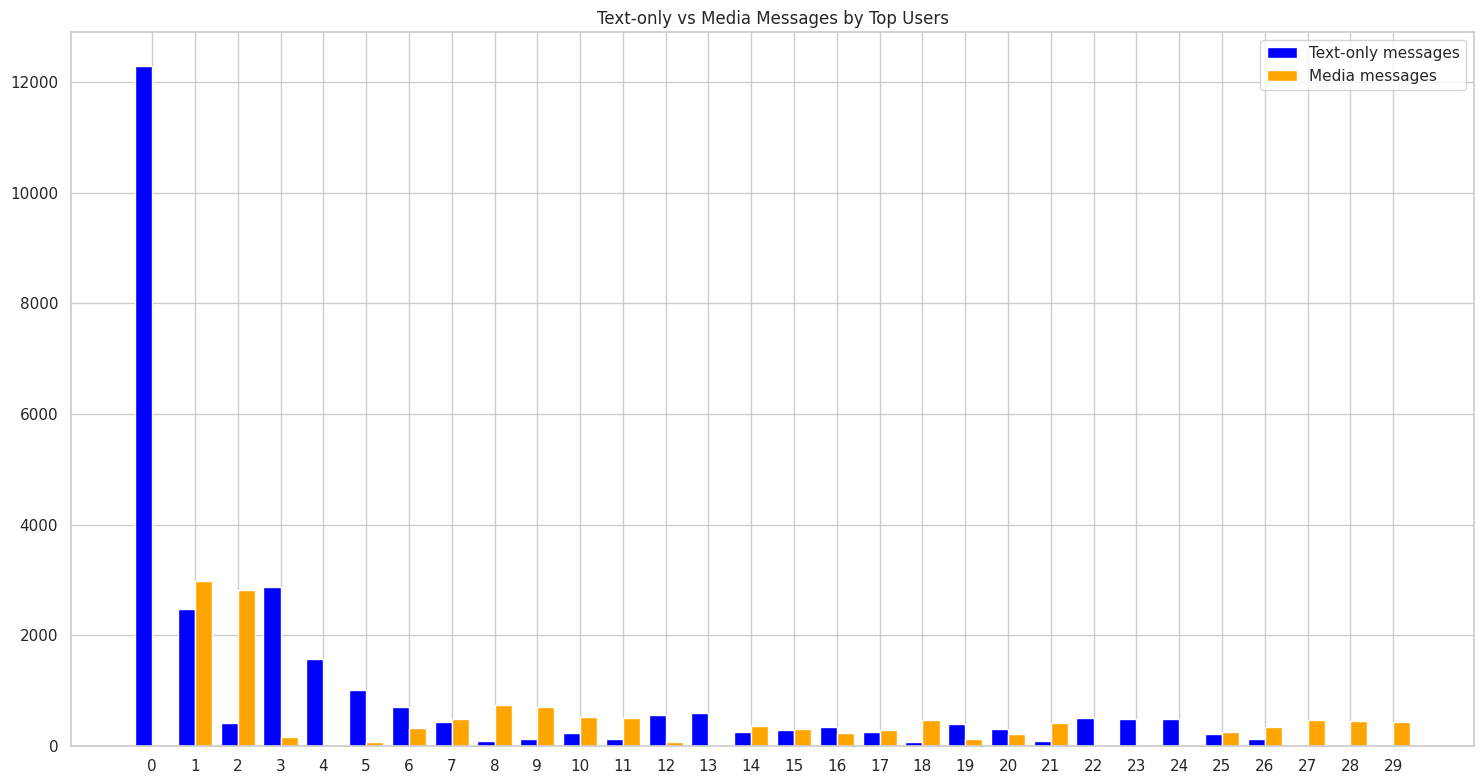

In [190]:
fig, ax = plt.subplots(figsize=(15, 8))

indices = range(len(top_users_breakdown))

bar_width = 0.4
ax.bar(indices, top_users_breakdown['text_only_messages'], width=bar_width, label='Text-only messages', color='blue')
ax.bar([i + bar_width for i in indices], top_users_breakdown['media_messages'], width=bar_width, label='Media messages', color='orange')

ax.set_xticks([i + bar_width/2 for i in indices])
ax.set_xticklabels(indices)
ax.set_title('Text-only vs Media Messages by Top Users')
ax.legend()
plt.tight_layout()
plt.show()

### 14. Os 30 usuários que mais compartilharam texto

In [191]:
top_users_text_only = conn.execute("""
SELECT
    id_member_anonymous,
    COUNT(*) AS text_only_messages
FROM messages
WHERE id_member_anonymous IS NOT NULL
GROUP BY id_member_anonymous
ORDER BY text_only_messages DESC
LIMIT 30
""").df()
top_users_text_only

,id_member_anonymous,text_only_messages
0,abe534d581ec6d552243d6955d3c3cd8,12289
1,1665e22b0f564cd46d343f7677014821,5452
2,1ac091b8ed5c4e42383f1b4ff4cc9b2d,3235
3,c743967449a387ad2c1c7e03b2c45b36,3017
4,d49f81df0c75d1d72bee6c5b2d707da0,1571
5,f233cf8b1d4ede06f32199a7e0081bf5,1085
6,e8fd8fee8c39342d37993775da7756d5,1027
7,e7998863ac2a40086657fab4a6b463c9,921
8,c052c859b42c5a1923c22f5a201de746,831
9,fa582c9e95da255e44f4c198d0daf3df,816


### 15. Os 30 Usuários que mais compartilharam mídias

In [193]:
top_users_text_only = conn.execute("""
SELECT
    id_member_anonymous,
    COUNT(CASE WHEN has_media THEN 1 ELSE null END) AS media_count
FROM messages
WHERE id_member_anonymous IS NOT NULL AND
    has_media = True
GROUP BY id_member_anonymous
ORDER BY media_count DESC
LIMIT 30
""").df()
top_users_text_only

,id_member_anonymous,media_count
0,1665e22b0f564cd46d343f7677014821,2972
1,1ac091b8ed5c4e42383f1b4ff4cc9b2d,2820
2,c052c859b42c5a1923c22f5a201de746,736
3,fa582c9e95da255e44f4c198d0daf3df,700
4,773b9bd5b02a2e96f9d732c29bfcb663,521
5,56b8359fd127312651b80b8ed8030085,501
6,e7998863ac2a40086657fab4a6b463c9,493
7,53e74af95497f943c524abaaa9482e33,460
8,9794a13f91433216821ad18624372498,458
9,5d321b03e74b751ac577ef022350306d,449


### 16. As 30 mensagens mais compartilhadas

In [195]:
top_shared_messages = conn.execute("""
SELECT text_content_anonymous as message, COUNT(*) AS total_shares
FROM messages WHERE message IS NOT NULL OR message != ''
GROUP BY message
ORDER BY total_shares DESC
LIMIT 30
""").df()
top_shared_messages

,message,total_shares
0,This community was blocked in Brazil following...,17422
1,سکس مردان ازبک با زن انگلیسی با این vpn از سای...,1019
2,فیلم سوپر با زیرنویس فارسی ببین😍😍\nبا این فیلت...,632
3,We had no choice but to remain in the shadows....,480
4,https://t.me/canalselvabrasiloficial\nSELVA BR...,461
5,🇮🇷 سکس با دختر 14 ساله را در سایتهای پورن\nبیی...,400
6,"""E conhecereis a verdade, e a verdade vos libe...",367
7,Bem vindo(a) ao grupo Ipirá Notícias. \n\nComp...,358
8,Vídeo de AVANY FERREIRA MULLER,195
9,Vídeo de Maria Teresa D Valente,189


### 17. As 30 mensagens mais compartilhadas em grupos diferentes

In [196]:
top_shared_messages_in_groups = conn.execute("""
SELECT text_content_anonymous as message, COUNT(DISTINCT id_group_anonymous) AS total_groups
FROM messages
WHERE message IS NOT NULL AND id_group_anonymous IS NOT NULL AND message != ''
GROUP BY message
ORDER BY total_groups DESC
LIMIT 30
""").df()
top_shared_messages_in_groups

,message,total_groups
0,This community was blocked in Brazil following...,59
1,BOA NOITE A TODOS. O QUE EU VOU DIZER É SÉRIO ...,36
2,Hoje às 18 horas no canal Inteligência Ltda do...,35
3,*ATENÇÃO* \n🚨🚨🚨🚨🚨🚨🚨🚨🚨\n\n*CHAMADA URGENTE* Pat...,29
4,Ajudem a subir a #JanonesAmigoDePedofilo\n\nPo...,29
5,"DE NADA IRÁ ADIANTAR FISCALIZAR AS URNAS, SE N...",29
6,OS PTISTAS NÃO QUER QUE AGENTE MOSTRE QUE VOTO...,29
7,"OS ELEITORES QUE JA ENVIOU, NÃO PRECISA MAIS E...",28
8,"BRASILEIROS, PIOR DE QUE VOCÊS PERDEREM SEUS C...",28
9,"Lançaram o Lulaflix, uma coletânea com o que d...",27


### 18. Mensagens idênticas compartilhadas pelo mesmo usuário (e suas quantidades)

In [199]:
repeated_messages_by_user = conn.execute("""
SELECT
    id_member_anonymous,
    text_content_anonymous,
    COUNT(*) AS total,
    COUNT(DISTINCT id_group_anonymous) AS total_groups
FROM messages
WHERE text_content_anonymous IS NOT NULL AND text_content_anonymous != ''
      AND id_member_anonymous IS NOT NULL
GROUP BY id_member_anonymous, text_content_anonymous
HAVING COUNT(*) > 1
ORDER BY total DESC
""").df()
repeated_messages_by_user

,id_member_anonymous,text_content_anonymous,total,total_groups
0,f233cf8b1d4ede06f32199a7e0081bf5,This community was blocked in Brazil following...,838,2
1,c743967449a387ad2c1c7e03b2c45b36,This community was blocked in Brazil following...,532,1
2,7696d5103cdb8ac352d748a1db1126b0,This community was blocked in Brazil following...,530,1
3,1665e22b0f564cd46d343f7677014821,Bem vindo(a) ao grupo Ipirá Notícias. \n\nComp...,357,1
4,a398999c55f8d6f0c65760522ae12e45,This community was blocked in Brazil following...,308,1
...,...,...,...,...
12232,891fb3d60150c739346ca09f1237643b,▪️💪🙏⚡⚔️🛡️👊💥\n\n✅SOS FFAA\n✅NÃO AO COMUNISMO\n✅...,2,2
12233,891fb3d60150c739346ca09f1237643b,Palavras dos anônimos patriotas que entendem. 💣⛓🔥,2,2
12234,c036e73cb7dae68e90f8fdc894ad0862,Palavras dos anônimos patriotas que entendem. 💣⛓🔥,2,1
12235,4c3e19a245184b0cc28467ad317477a1,"Karina Michelin, conseguiu subir esse vídeo, p...",2,2


### 19. Mensagens idênticas compartilhadas pelo mesmo usuário em grupos distintos (e suas quantidades)

In [200]:
repeated_messages_by_user_groups = conn.execute("""
SELECT
    id_member_anonymous,
    text_content_anonymous as message,
    COUNT(DISTINCT id_group_anonymous) AS total_groups
FROM messages
WHERE text_content_anonymous IS NOT NULL
      AND message != ''
      AND id_member_anonymous IS NOT NULL
      AND id_group_anonymous IS NOT NULL
GROUP BY id_member_anonymous, message
HAVING COUNT(DISTINCT id_group_anonymous) > 1
ORDER BY total_groups DESC
""").df()
repeated_messages_by_user_groups

,id_member_anonymous,message,total_groups
0,a7840e7844020149e197272748965862,ALERTA\nESSE GRUPO FOI CRIADO PELA ESQUERDA CO...,16
1,326d0a2f1bc5a1ede446fcf5dc31ff2e,💣💥((((( URGENTÍSSIMO )))))💥💣\nESSE GRUPO É UMA...,14
2,326d0a2f1bc5a1ede446fcf5dc31ff2e,💣💣💣💥💥🔰BOMBA BOMBA🔰💥💥💣💣💣\nVCS ESTÃO ACHANDO QUE...,12
3,29dda76df3384c28a07e8bad1ee9ceed,BOA NOITE A TODOS. O QUE EU VOU DIZER É SÉRIO ...,11
4,4e93f1d3c83fd6041314517363b14ed5,Pessoal não envie seus comprovantes de votação...,10
...,...,...,...
8261,a53def757196b3999ba6681430fc875c,URGENTE: Deputado protocola pedido de Garantia...,2
8262,f0a68345809652fc96ce3ec4241c4f62,https://youtu.be/hVxlr3qSLW0\n\nEssa Palavra v...,2
8263,a53def757196b3999ba6681430fc875c,STJ anula provas obtidas contra traficante abo...,2
8264,abe534d581ec6d552243d6955d3c3cd8,"Welcome, Juh\n\n🔸 [USER] — professional tool f...",2


### 20. Os 30 unigramas, bigramas e trigramas mais compartilhados (após a remoção de stopwords)

In [243]:
base_query = """
FROM (
    SELECT unnest(string_split_regex(lower(text_no_stopwords), '[^\p{L}0-9]+')) AS word
    FROM messages
    WHERE text_no_stopwords IS NOT NULL AND text_no_stopwords != ''
)
WHERE word NOT LIKE 'http%'
  AND word NOT LIKE 'www%'
  AND word NOT LIKE 'com%'
  AND word NOT LIKE 't.me%'
  AND word NOT LIKE 'youtu%'
  AND length(word) > 1
"""

#### Unigramas

In [ ]:
top_30_1gram = conn.execute(f"""
SELECT
    word AS ngram,
    COUNT(*) AS total
{base_query}
GROUP BY word
ORDER BY total DESC
LIMIT 30;
""").df()

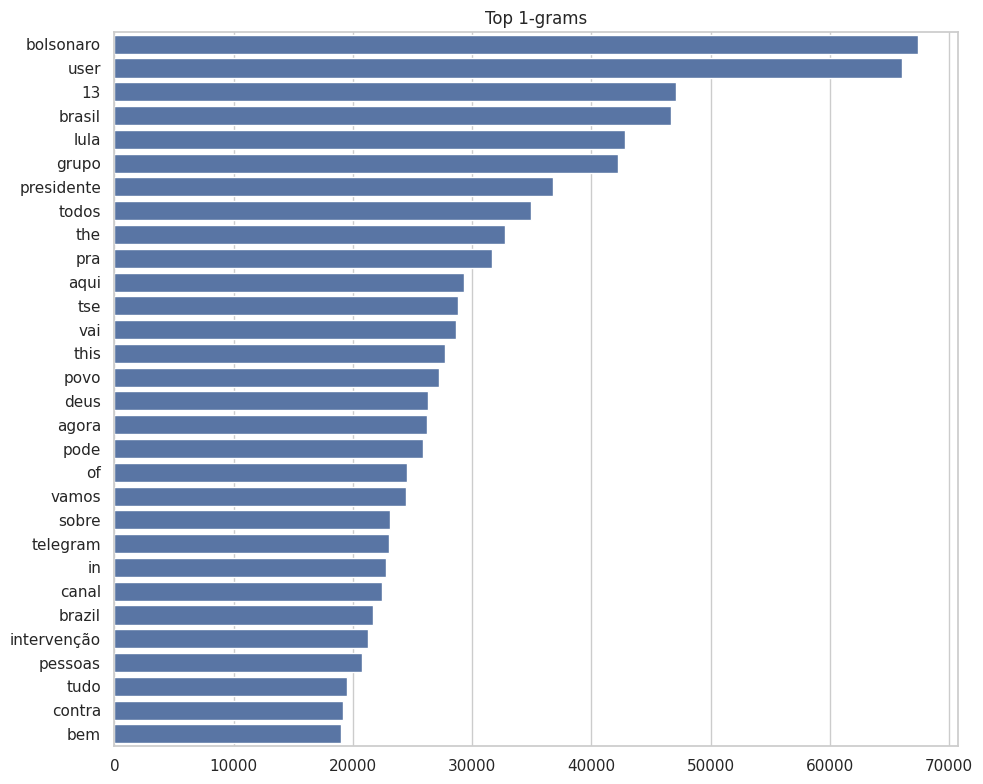

In [246]:
plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_30_1gram,
    x='total',
    y='ngram',
)

plt.title('Top 1-grams')
plt.xlabel(None)
plt.ylabel(None)
plt.tight_layout()

plt.show()

#### Bigramas

In [ ]:
query = f"""
WITH tokens AS (
    SELECT word
    {base_query}
),
ngrams AS (
    SELECT
        word || ' ' || lead(word, 1) OVER () as two_gram
    FROM tokens
)
SELECT
    two_gram as "2gram",
    count(*) as count
FROM ngrams
WHERE two_gram NOT LIKE '% % %'
GROUP BY two_gram
ORDER BY count DESC
LIMIT 30;
"""
top_2grams = conn.execute(query).df()

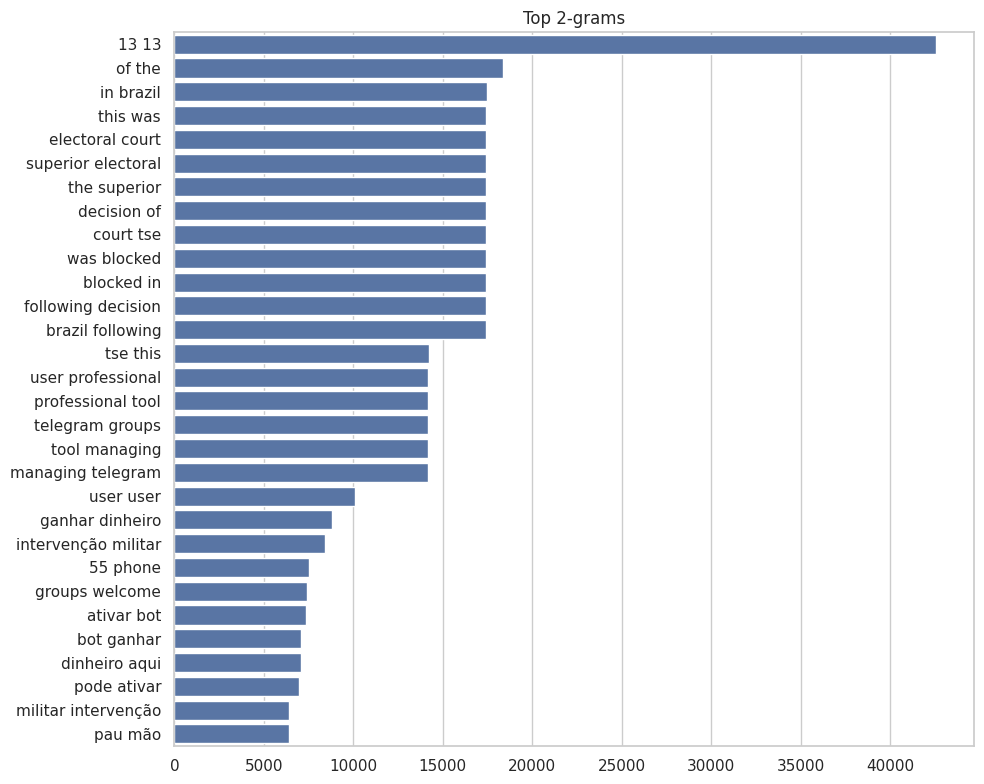

In [248]:
plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_2grams,
    x='count',
    y='2gram',
)

plt.title('Top 2-grams')
plt.xlabel(None)
plt.ylabel(None)
plt.tight_layout()

plt.show()

#### Trigramas

In [ ]:
query = f"""
WITH tokens AS (
    SELECT word
    {base_query}
),
ngrams AS (
    SELECT
        word || ' ' || lead(word, 1) OVER () || ' ' || lead(word, 2) OVER () AS three_gram
    FROM tokens
)
SELECT
    three_gram AS "3gram",
    count(*) AS count
FROM ngrams
WHERE three_gram NOT LIKE '% % % %'
GROUP BY three_gram
ORDER BY count DESC
LIMIT 30;
"""
top_3grams = conn.execute(query).df()

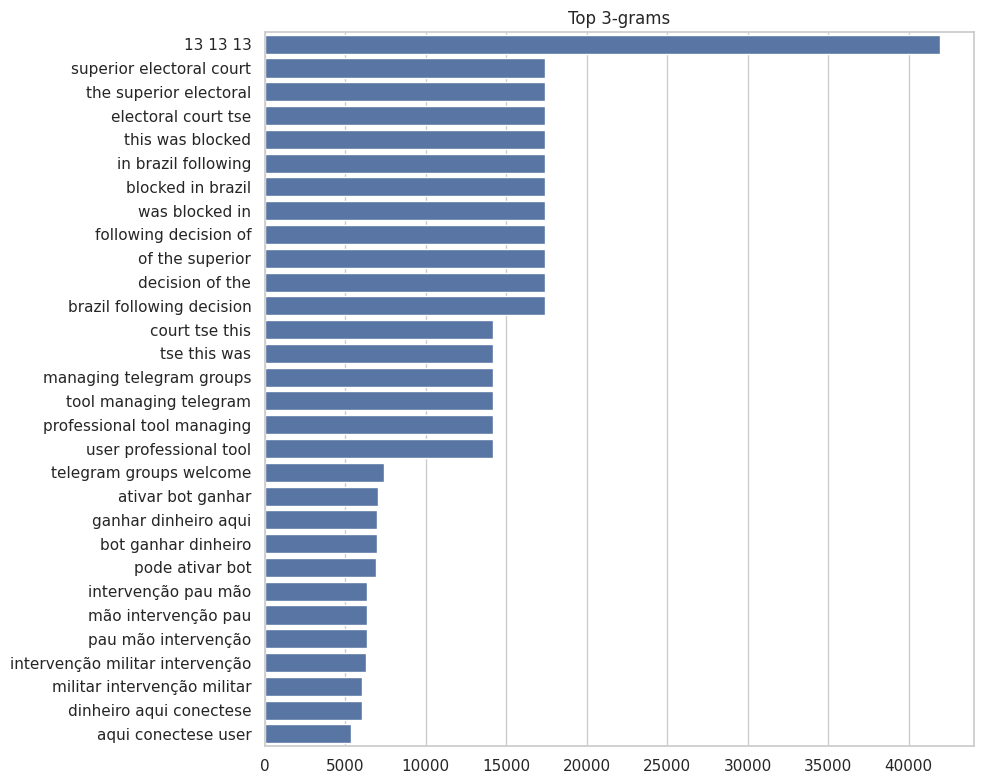

In [250]:
plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_3grams,
    x='count',
    y='3gram',
)

plt.title('Top 3-grams')
plt.xlabel(None)
plt.ylabel(None)
plt.tight_layout()

plt.show()

### 21. As 30 mensagens mais positivas (distintas)

In [256]:
top_positive_messages = conn.execute("""
SELECT DISTINCT text_content_anonymous as message, score_sentiment
FROM messages
WHERE message IS NOT NULL
  AND message != ''
  AND score_sentiment IS NOT NULL AND score_sentiment >= 0.05
ORDER BY score_sentiment DESC
LIMIT 30;
""").df()
top_positive_messages

,message,score_sentiment
0,"Shemoneh Esreh – Amidá – A Grande Oração\n\n ,...",0.9992
1,"MENTIROSA!!!\n\n\nPensa direita, não é correto...",0.9990
2,"Pensa direita, não é correto compartilhar um v...",0.9990
3,"בונה ירושלים, Bo'ne Yetrushalayim - Benção da ...",0.9989
4,Os Sete Samurais \n \nQuando falamos sobre For...,0.9988
5,MANIFESTO À NAÇÃO BRASILEIRA\n\nEM DEFESA DO B...,0.9987
6,"Olá ,\n\nUM AMIGO ME PERGUNTOU EM QUEM EU VOTE...",0.9986
7,BOM DIA A TODOS. ENTENDO QUE ESTAMOS VIVENDO D...,0.9986
8,Uma forma bem legal\nPara quem ainda não sabe ...,0.9985
9,\nA Viva Esperança\n\nDepois das saudações in...,0.9985


### 22. As 30 mensagens mais negativsas (distintas)

In [258]:
top_negative_messages = conn.execute("""
SELECT DISTINCT text_content_anonymous, score_sentiment
FROM messages
WHERE text_content_anonymous IS NOT NULL
  AND text_content_anonymous != ''
  AND score_sentiment IS NOT NULL AND score_sentiment <= 0.05
ORDER BY score_sentiment ASC
LIMIT 30;
""").df()
top_negative_messages

,text_content_anonymous,score_sentiment
0,CAPITÃOZINHO DE MERDA 💩\nCAPITÃOZINHO DE MERDA...,-1.0000
1,"Gente, a Zambelli nos abandonou! Traiu a nossa...",-0.9999
2,ai ta na rua da um joinha 👍Quem ai ta na rua d...,-0.9999
3,"E nós aqui nos sacrificando, aguentando sol, c...",-0.9999
4,ME CÚ NO PAU DO BOLSONARO \nME CÚ NO PAU DO BO...,-0.9999
5,Intervenção é meu pau na tua mão\nIntervenção ...,-0.9999
6,Intervenção é meu pau na tua mão\nIntervenção ...,-0.9999
7,ta na rua da um joinha 👍Quem ai ta na rua da u...,-0.9998
8,ha 👍Quem ai ta na rua da um joinha 👍Quem ai ta...,-0.9998
9,na rua da um joinha 👍Quem ai ta na rua da um j...,-0.9998


### 23. O usuário mais otimista

In [259]:
top_positive_user = conn.execute("""
SELECT
    id_member_anonymous,
    AVG(score_sentiment) AS avg_sentiment,
    COUNT(*) AS total_messages
FROM messages
WHERE score_sentiment IS NOT NULL
  AND id_member_anonymous IS NOT NULL
GROUP BY id_member_anonymous
ORDER BY avg_sentiment DESC
LIMIT 1;
""").df()
top_positive_user

,id_member_anonymous,avg_sentiment,total_messages
0,5d0e50d6d2183bf16ec637ed24131870,0.9967,1


In [261]:
top_positive_user_10 = conn.execute("""
SELECT
    id_member_anonymous,
    AVG(score_sentiment) AS avg_sentiment,
    COUNT(*) AS total_messages
FROM messages
WHERE score_sentiment IS NOT NULL
  AND id_member_anonymous IS NOT NULL
GROUP BY id_member_anonymous
HAVING COUNT(*) >= 10
ORDER BY avg_sentiment DESC
LIMIT 1;
""").df()
top_positive_user_10

,id_member_anonymous,avg_sentiment,total_messages
0,bab79a5f7c599d5b5b9155d5d3d8b570,0.92,25


### 24. O usuário mais pessimista

In [262]:
top_negative_user = conn.execute("""
SELECT
    id_member_anonymous,
    AVG(score_sentiment) AS avg_sentiment,
    COUNT(*) AS total_messages
FROM messages
WHERE score_sentiment IS NOT NULL
  AND id_member_anonymous IS NOT NULL
GROUP BY id_member_anonymous
ORDER BY avg_sentiment ASC
LIMIT 1;
""").df()
top_negative_user

,id_member_anonymous,avg_sentiment,total_messages
0,243a43d802953032e1ea9a363546c3b8,-0.9992,1


In [264]:
top_negative_user_10 = conn.execute("""
SELECT
    id_member_anonymous,
    AVG(score_sentiment) AS avg_sentiment,
    COUNT(*) AS total_messages
FROM messages
WHERE score_sentiment IS NOT NULL
  AND id_member_anonymous IS NOT NULL
GROUP BY id_member_anonymous
HAVING COUNT(*) >= 10
ORDER BY avg_sentiment ASC
LIMIT 1;
""").df()
top_negative_user_10

,id_member_anonymous,avg_sentiment,total_messages
0,525aacc8e246df1885c5d1ee2feec506,-0.93254,15


### 25. As 30 maiores mensagens

In [272]:
top_longest_messages = conn.execute("""
SELECT
    DISTINCT text_content_anonymous
    id_member_anonymous,
    LENGTH(text_content_anonymous) AS message_length,
FROM messages
WHERE text_content_anonymous IS NOT NULL
  AND text_content_anonymous != ''
ORDER BY message_length DESC
LIMIT 30;
""").df()
top_longest_messages

,id_member_anonymous,message_length
0,[Encaminhado de FYI-Brasil (Sú)]\n🚨ELEIÇÕES DE...,4096
1,1: Naqueles dias não havia melech em Yisra-EL;...,4096
2,"1: Aconteceu também naqueles dias, quando não ...",4096
3,ROIA♘ ♞HERON★�CAVALO★§�DE★§�§TROIA♘ ♞HERON★�CA...,4096
4,Trecho do livro “Prática da Conspiração A Agen...,4096
5,COMO O SOCIALISMO DESTRUIU A VENEZUELA EM POUC...,4096
6,PROPOSTAS DE BOLSONARO PARA 2023 - POSTADAS AG...,4096
7,"1: Sansão foi a Gaza, e viu ali uma prostituta...",4096
8,1 – A Estratégia da Distração.\n\nO elemento p...,4095
9,Sobre a morte como política global e a necessi...,4095


### 26. As 30 menores mensagens

In [271]:
top_shortest_messages = conn.execute("""
SELECT
    DISTINCT text_content_anonymous,
    id_member_anonymous,
    LENGTH(text_content_anonymous) AS message_length,
FROM messages
WHERE text_content_anonymous IS NOT NULL
  AND text_content_anonymous != ''
ORDER BY message_length ASC
LIMIT 30;
""").df()
top_shortest_messages

,text_content_anonymous,id_member_anonymous,message_length
0,*S I N A L*,None,12
1,Sou do R G S,None,12
2,Aí aí aí ui ui,None,14
3,🌩\n\n🇧🇷\n\nPois é 🙈,04d25416106623950c5b8785235ef1f9,15
4,É esse o site ?,a2921b315ad9351b6c0eeedb8c200fbc,15
5,Foto de A Í D A,None,15
6,A bolsa fez o L,None,15
7,"I have sent it ,",None,16
8,Foto de 🎀 VIVI 🎀,None,16
9,É o fim do mundo,52457463d47ef753173a8717f02a21b3,16


### 27. O dia em que foi publicado a maior quantidade de mensagens

In [273]:
day_with_most_messages = conn.execute("""
SELECT
    CAST(date_message AS DATE) AS message_day,
    COUNT(*) AS total_messages
FROM messages
WHERE date_message IS NOT NULL
GROUP BY message_day
ORDER BY total_messages DESC
LIMIT 1;
""").df()
day_with_most_messages

,message_day,total_messages
0,2022-11-01,18474


In [276]:
top10_days_with_most_messages = conn.execute("""
SELECT
    CAST(date_message AS DATE) AS message_day,
    COUNT(*) AS total_messages
FROM messages
WHERE date_message IS NOT NULL
GROUP BY message_day
ORDER BY total_messages DESC
LIMIT 10;
""").df()
top10_days_with_most_messages

,message_day,total_messages
0,2022-11-01,18474
1,2022-10-31,15271
2,2022-10-03,13003
3,2022-10-05,12641
4,2022-11-02,12606
5,2022-10-02,11309
6,2022-10-04,10424
7,2022-10-30,9518
8,2022-10-06,8611
9,2022-10-12,8509


### 28. As mensagens que possuem as palavras "Facção" e "Criminosa"

In [281]:
messages_with_faction_and_criminal = conn.execute("""
SELECT
    id_message,
    id_member_anonymous,
    text_content_anonymous
FROM messages
WHERE text_content_anonymous IS NOT NULL
  AND LOWER(text_content_anonymous) LIKE '%facção%'
  AND LOWER(text_content_anonymous) LIKE '%criminosa%'
""").df()
messages_with_faction_and_criminal

,id_message,id_member_anonymous,text_content_anonymous
0,19285,None,"Pensem!!!!!!'Se Houve fraude ,Nada foi feito ..."
1,105417,530db5d239f941ef44aae189f20b44a2,"Se depois de ler esse resumo do Plano do PT, v..."
2,1090985,530db5d239f941ef44aae189f20b44a2,"Se depois de ler esse resumo do Plano do PT, v..."
3,1097866,None,É exatamente isso que a facção criminosa CHAM...
4,1098563,None,Esperar o que dessa eleição com bandidos alia...
...,...,...,...
133,1210244,None,😣🤯🤐 Alexandre de Moraes (Secretário-Geral do P...
134,973541,None,😣🤯🤐 Alexandre de Moraes (Secretário-Geral do P...
135,19115,None,😣🤯🤐 Alexandre de Moraes (Secretário-Geral do P...
136,53201,76b7d0b3c652aaefb984081e503af0eb,Agressões covardes é termos uma facção crimino...


### 29. Quantidade de mensagens por dia e hora

In [293]:
df_clean['date_message'] = pd.to_datetime(df_clean['date_message'])

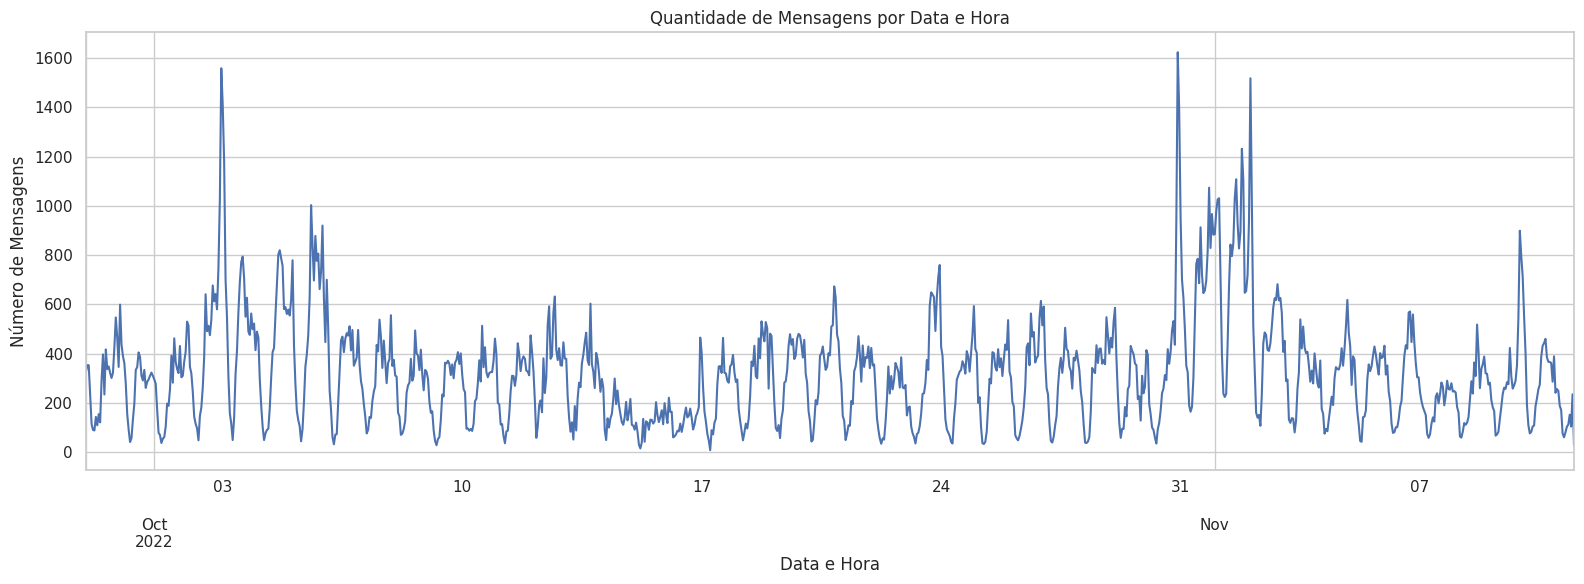

In [294]:
df_clean['date_hour'] = df_clean['date_message'].dt.floor('h')

hourly_counts = df_clean.groupby('date_hour').size()

plt.figure(figsize=(16, 6))
hourly_counts.plot()

plt.title('Quantidade de Mensagens por Data e Hora')
plt.xlabel('Data e Hora')
plt.ylabel('Número de Mensagens')
plt.tight_layout()
plt.grid(True)
plt.show()

### 30. Quantidade de mensagens por hora

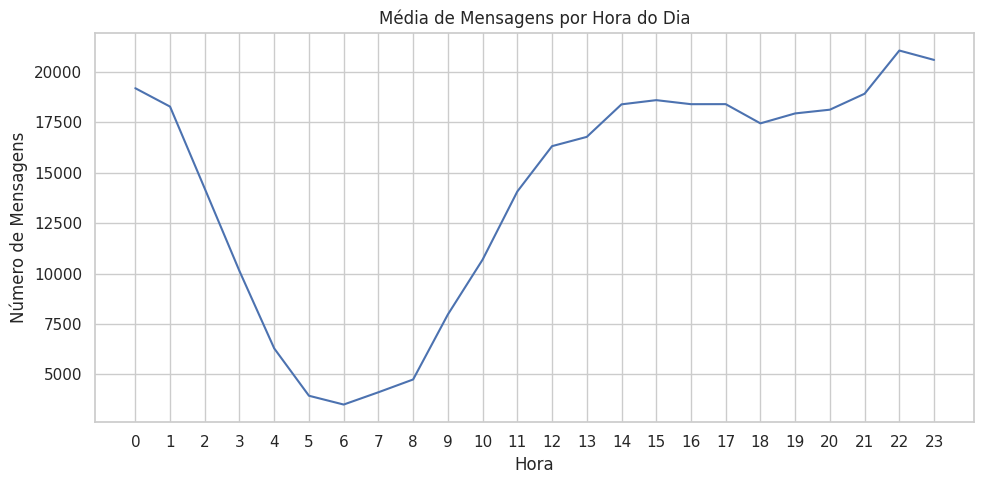

In [299]:
df_clean['hour'] = df_clean['date_message'].dt.hour

hourly_avg = df_clean.groupby('hour').size()

plt.figure(figsize=(10, 5))
hourly_avg.plot()

plt.title('Média de Mensagens por Hora do Dia')
plt.xlabel('Hora')
plt.ylabel('Número de Mensagens')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

### 31. A nuvem de palavras referente às mensagens de texto (após a remoção de stopwords)

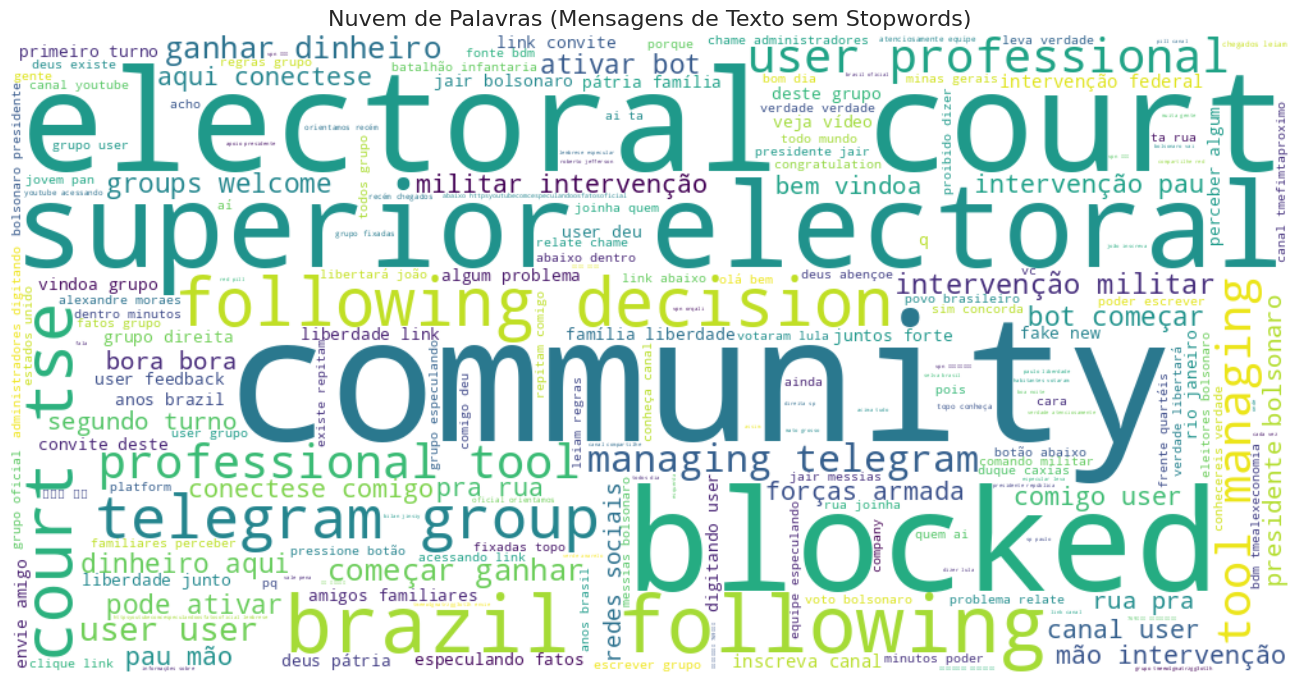

In [304]:
text = ' '.join(df_clean['text_no_stopwords'].dropna().astype(str)).lower()

wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    max_words=200
).generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras (Mensagens de Texto sem Stopwords)', fontsize=16)
plt.tight_layout()
plt.show()

### 32. A rede interativa das palavras referentes às mensagens de texto (após a remoção de stopwords)

### 33. Proporção de mensagens com e sem URL

### 34. Proporção de desinformação

### 35. Proporção de mensagens contendo mídia e desinformação

### 36. Distribuição de mensagens por score de desinformação

### 37. Proporção de sentimentos

### 38. Distribuição de mensagens por score de sentimento

### 39. Proporção entre mensagens virais e não virais

### 40. Algo que você julga importante que ainda não foi solicitado